## Let's do some imports first ##

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.signal import savgol_filter
import glob
import pickle
from datetime import datetime
from tqdm import tqdm

## Now we want to load the dataset 

What we are interested in here is the SBP and Threshold Crossings Values 

In [2]:
from population_level_analyses import *
%load_ext autoreload
%autoreload 2

In [3]:
mpath = path = os.path.join("..", "..","..", "AdaptiveAlignment", "data", "hisham_current", 'preprocessing_092024_no7822nofalcon')

### LOAD AND PREPROCESS DATA ###
results = load_all_datasets(mpath)

Processing datasets:   2%|▏         | 8/384 [00:00<00:05, 74.96it/s]

385


Processing datasets: 100%|██████████| 384/384 [00:05<00:00, 69.67it/s]


## Now let's prepare the data for visualization ##

In [4]:
### PREPARE DATA FOR VISUALIZATION ###
df_tuning = prepare_tuning_data(results)

2020-01-27 00:00:00
2020-01-30 00:00:00
2020-02-04 00:00:00
2020-02-05 00:00:00
2020-02-06 00:00:00
2020-02-22 00:00:00
2020-02-24 00:00:00
2020-02-25 00:00:00
2020-02-28 00:00:00
2020-03-02 00:00:00
2020-03-10 00:00:00
2020-03-12 00:00:00
2020-03-13 00:00:00
2020-03-17 00:00:00
2020-03-18 00:00:00
2020-03-19 00:00:00
2020-03-20 00:00:00
2020-06-24 00:00:00
2020-06-26 00:00:00
2020-07-08 00:00:00
2020-07-28 00:00:00
2020-07-29 00:00:00
2020-07-31 00:00:00
2020-08-04 00:00:00
2020-08-08 00:00:00
2020-08-11 00:00:00
2020-08-12 00:00:00
2020-08-22 00:00:00
2020-08-24 00:00:00
2020-08-26 00:00:00
2020-08-27 00:00:00
2020-08-28 00:00:00
2020-08-29 00:00:00
2020-08-31 00:00:00
2020-09-04 00:00:00
2020-09-05 00:00:00
2020-09-06 00:00:00
2020-09-07 00:00:00
2020-09-12 00:00:00
2020-09-16 00:00:00
2020-09-18 00:00:00
2020-09-19 00:00:00
2020-09-21 00:00:00
2020-09-22 00:00:00
2020-09-23 00:00:00
2020-09-24 00:00:00
2020-09-28 00:00:00
2020-09-29 00:00:00
2020-10-02 00:00:00
2020-10-07 00:00:00


## Lets look at some dimensionality of our data.

First, we want to calculate how the components needed to explain 80% of the variance (using PCA) changes over time. To do this, we first need to do PCA and calculate the cumulative variance over time.

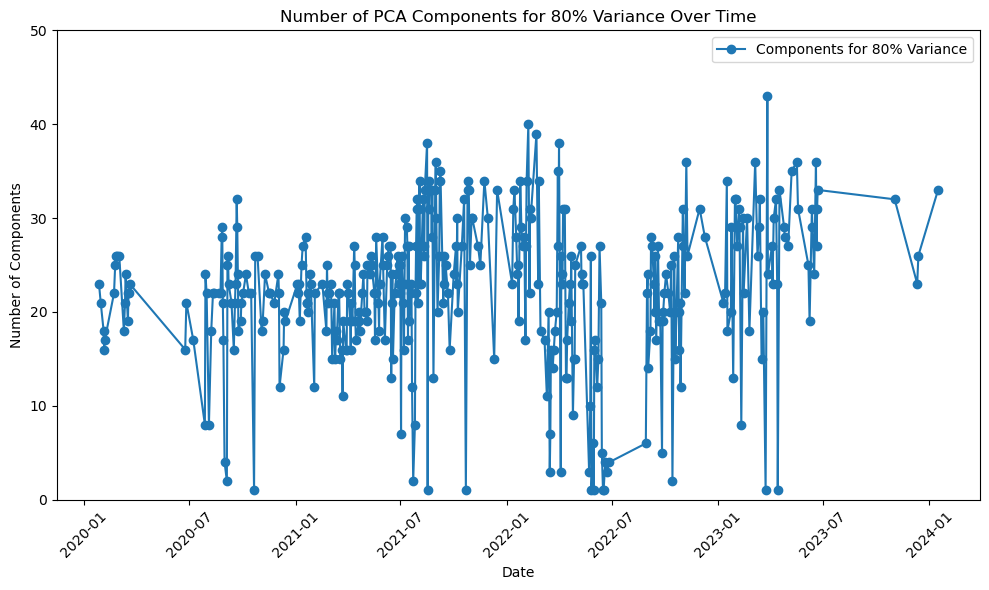

In [5]:
pca_results = day_by_day_PCA(df_tuning)

Now,lets plot and see what we get. You'll notice that the components decrease when the data was weird (summer of 2022), but the general trend is a slight increase over time (though there does seem to be more variance as time goes on as well)

Another way of looking at the same data is to break it down into quarters and visualize it on different axes. The same patterns hold here though (as it is the same data). It does seem easier to see here that while over time there is a slight increase in # of components needed for 80%, its not that drastic. 

/home/riopar/anaconda3/envs/adaptive_alignment_bk/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/home/riopar/anaconda3/envs/adaptive_alignment_bk/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/home/riopar/anaconda3/envs/adaptive_alignment_bk/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/home/riopar/anaconda3/envs/adaptive_alignment_bk/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/home/riopar/anaconda3/envs/adaptive_alignment_bk/lib/python3.12/site-packages/sklearn/d

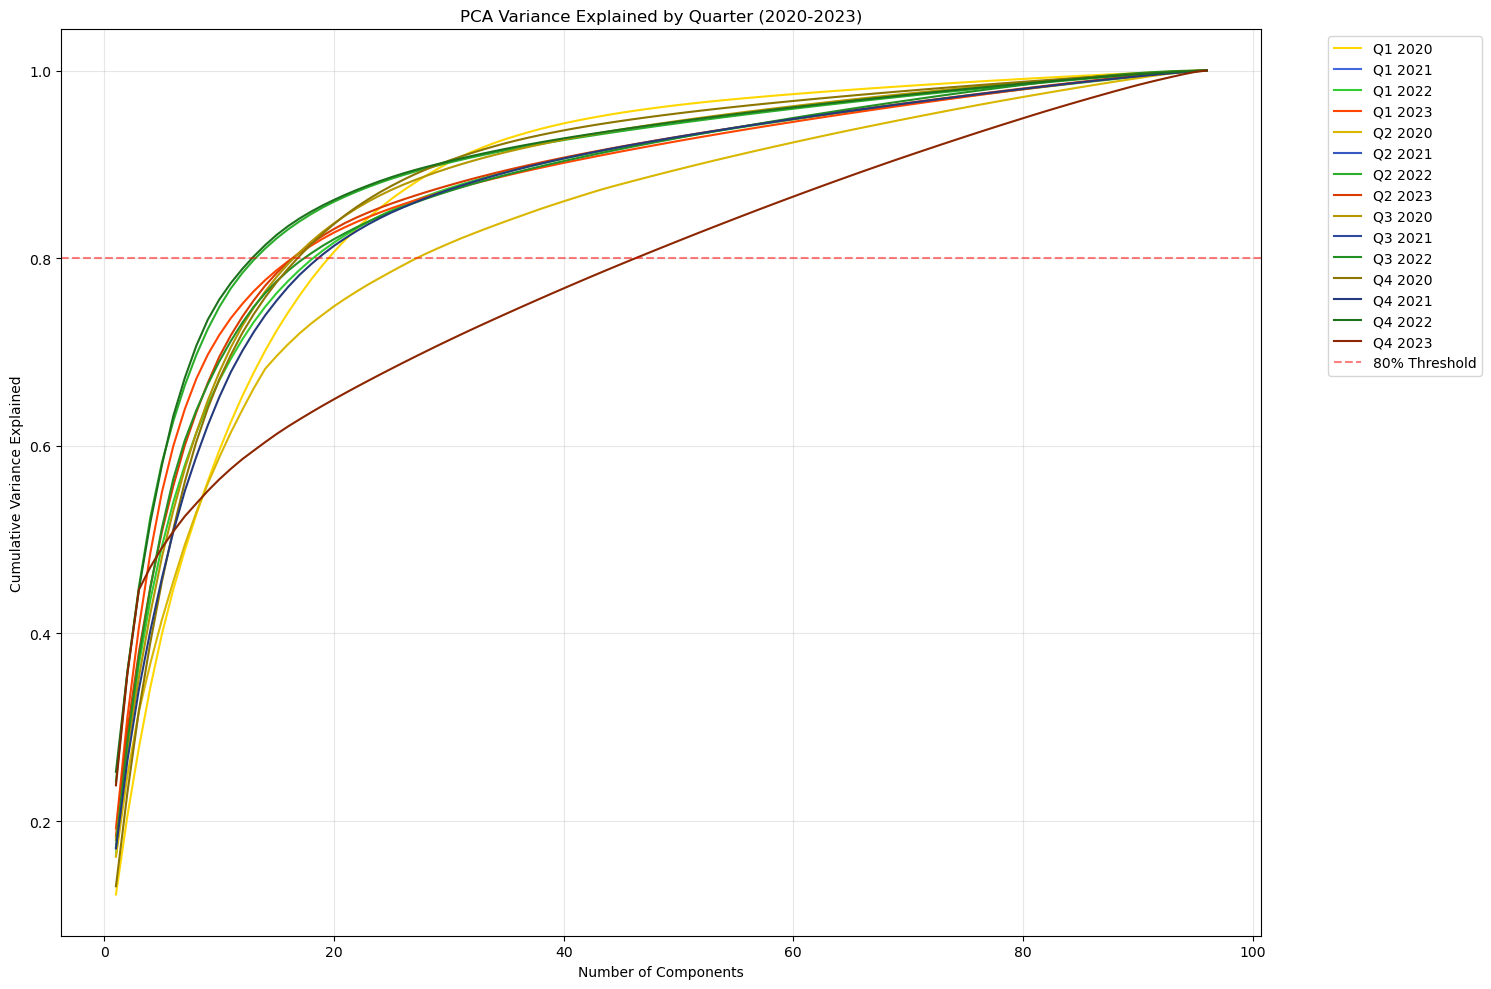

In [6]:
explained_var_over_time(df_tuning)

### PCA of Reach Directions

One other cool thing we can do is take a look at our Center Out (CO) tasks, and look at how the dimensionality of the reach directions is changing with time

Calculated PCA
Trimmed Data
Averaged PCA


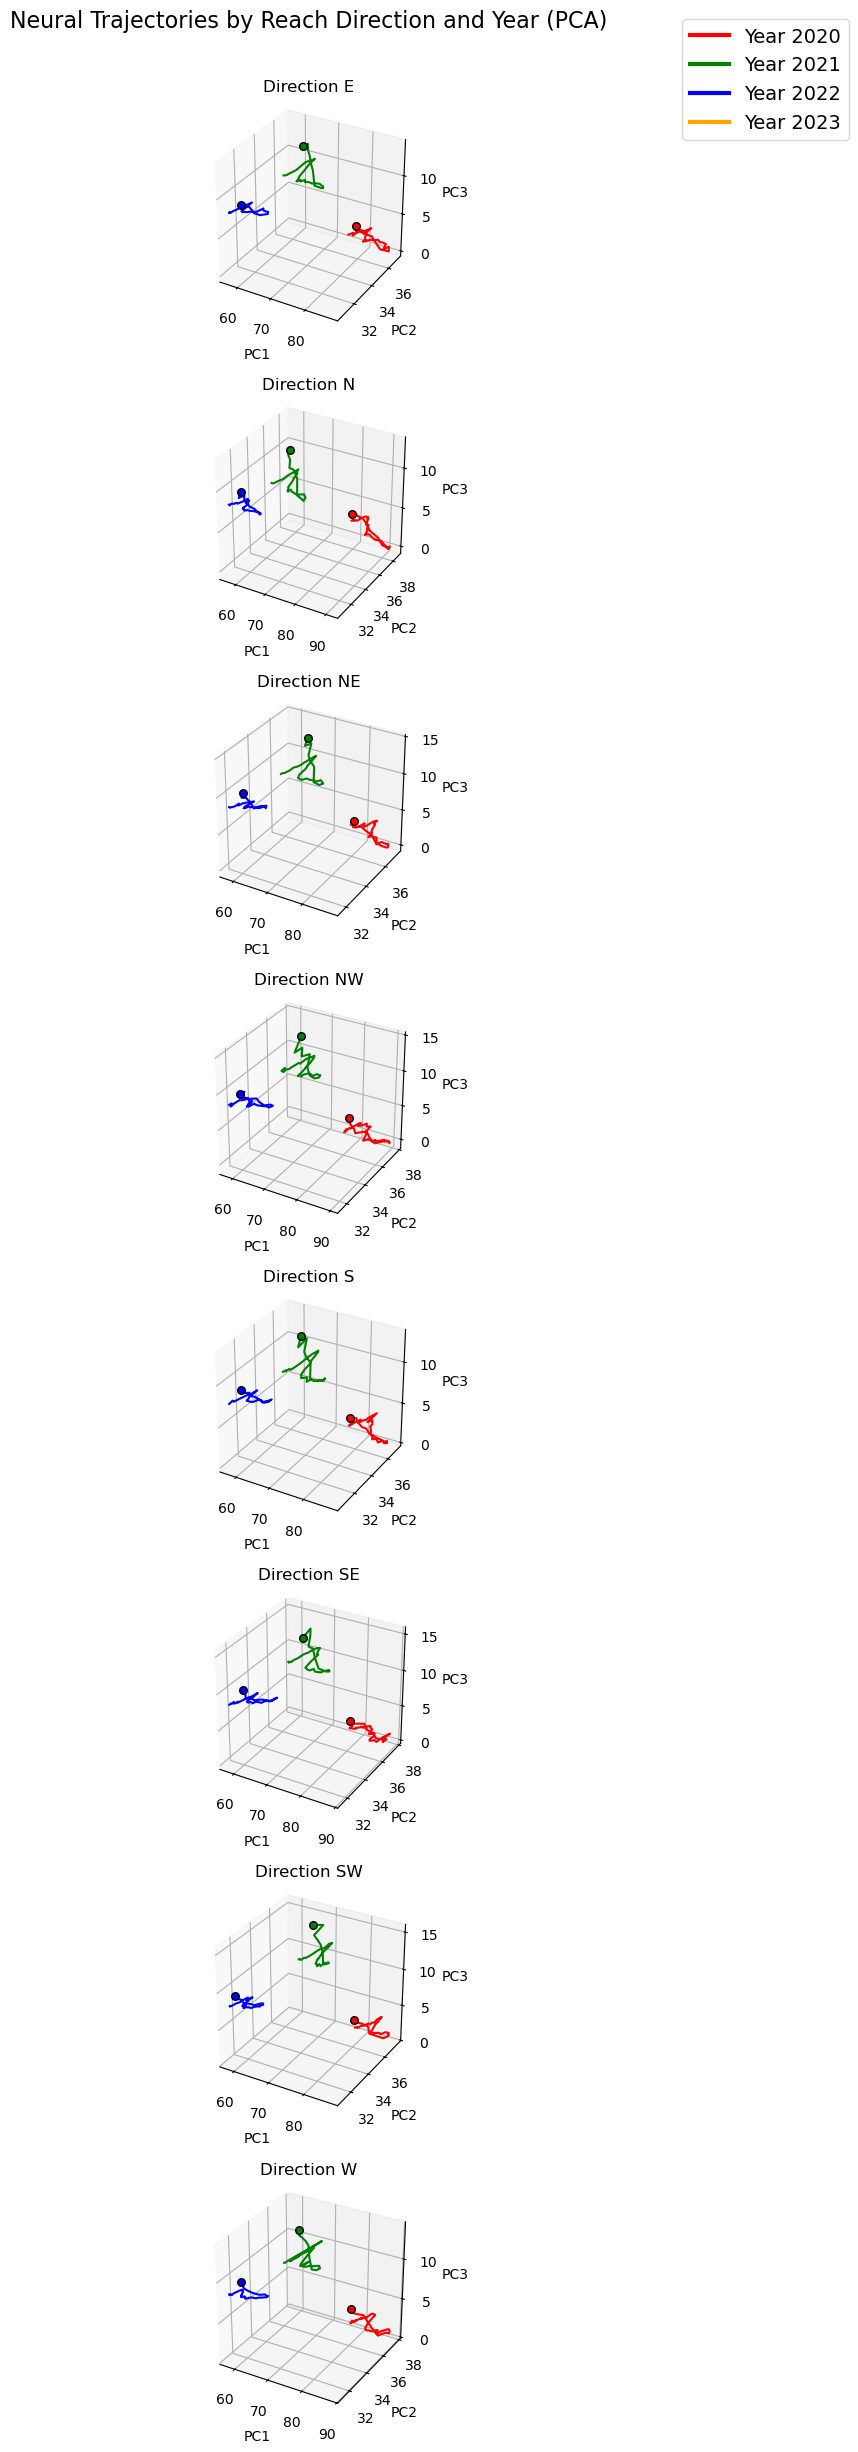

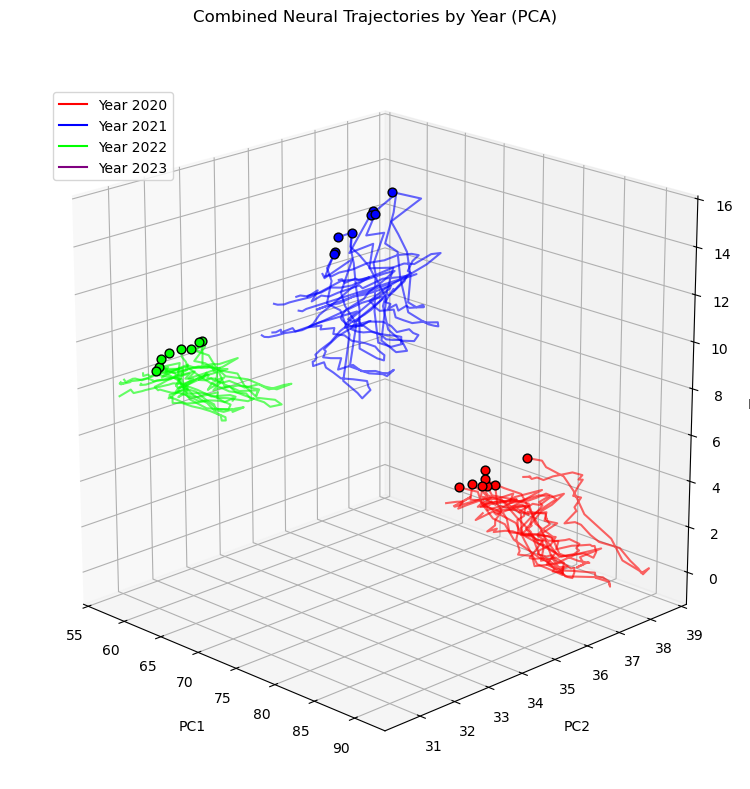

/home/riopar/Documents/repos/LINK_dataset/analysis/populationlevelanalyses/population_level_analyses.py:698: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


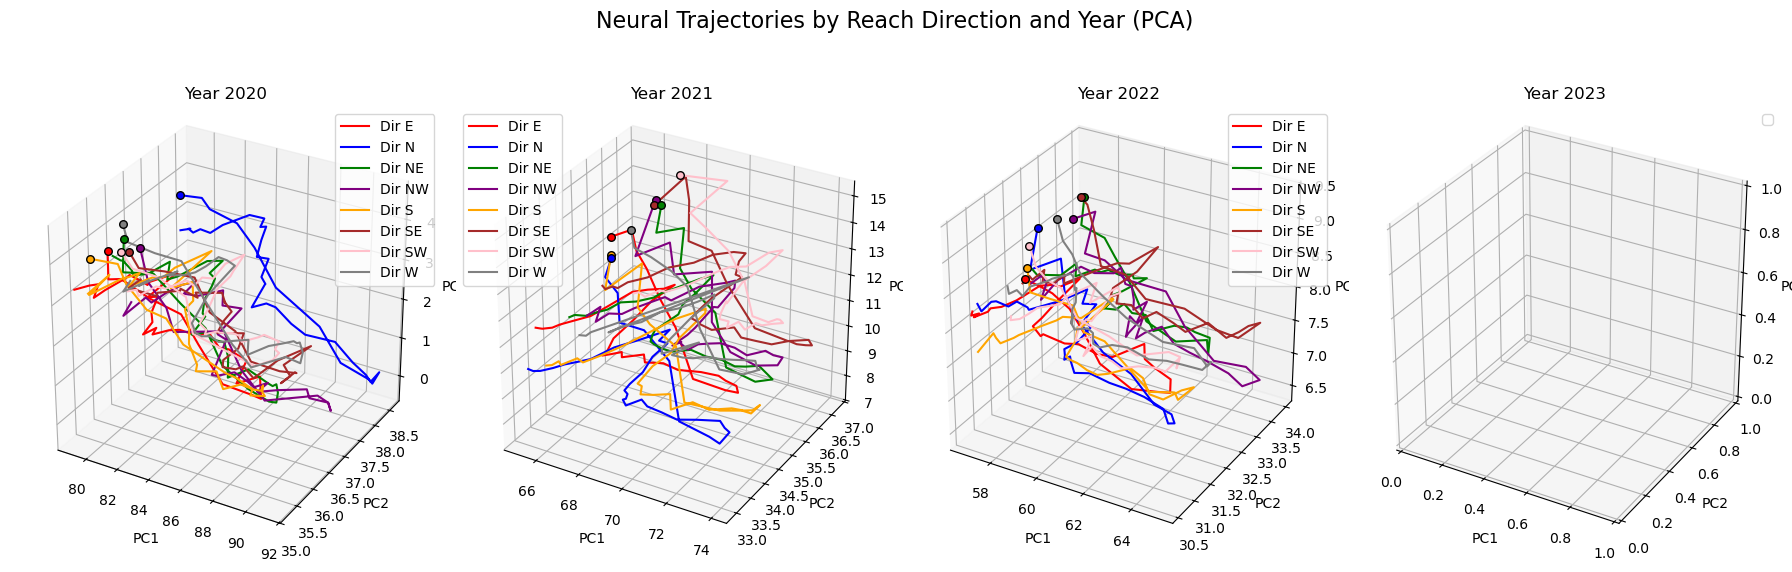

In [ ]:
pca_of_reach_directions(df_tuning=df_tuning, type_of_data="sbps", smoothing=False)
#pca_of_reach_directions(df_tuning=df_tuning, type_of_data="tcfr", smoothing=False)


In [12]:
# import matplotlib.pyplot as plt

# years = entanglement_results.keys()
# sbp_entanglement = [np.mean(list(entanglement_results[year].values())) for year in years]
# tcfr_entanglement = [np.mean(list(entanglement_results_tcfr[year].values())) for year in years]

# plt.plot(years, sbp_entanglement, label="SBP Entanglement", marker="o")
# plt.plot(years, tcfr_entanglement, label="TCFR Entanglement", marker="s")
# plt.xlabel("Year")
# plt.ylabel("Entanglement Index")
# plt.legend()
# plt.title("Entanglement Over Time")
# plt.show()

NameError: name 'entanglement_results' is not defined